In [34]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
## using keggle datasets 
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [36]:
file_loc = '../datasets/manga.csv'
file_url = " -- to be added later -- "
df = pd.read_csv(file_loc)

In [37]:
df.columns

Index(['manga_id', 'title', 'type', 'score', 'scored_by', 'status', 'volumes',
       'chapters', 'start_date', 'end_date', 'members', 'favorites', 'sfw',
       'approved', 'created_at_before', 'updated_at', 'real_start_date',
       'real_end_date', 'genres', 'themes', 'demographics', 'authors',
       'serializations', 'synopsis', 'background', 'main_picture', 'url',
       'title_english', 'title_japanese', 'title_synonyms'],
      dtype='object')

In [38]:
df_new = df[['manga_id','title','score','status','favorites','genres','type','start_date', 'chapters']]
df_new.head()

,manga_id,title,score,status,favorites,genres,type,start_date,chapters
0,2,Berserk,9.47,currently_publishing,119470,"['Action', 'Adventure', 'Award Winning', 'Dram...",manga,1989-08-25,NaN
1,13,One Piece,9.22,currently_publishing,111462,"['Action', 'Adventure', 'Fantasy']",manga,1997-07-22,NaN
2,1706,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,9.30,finished,41713,"['Action', 'Adventure', 'Mystery', 'Supernatur...",manga,2004-01-19,96.0
3,4632,Oyasumi Punpun,9.02,finished,49361,"['Drama', 'Slice of Life']",manga,2007-03-15,147.0
4,25,Fullmetal Alchemist,9.03,finished,29634,"['Action', 'Adventure', 'Award Winning', 'Dram...",manga,2001-07-12,116.0


In [39]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64833 entries, 0 to 64832
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   manga_id    64833 non-null  int64  
 1   title       64833 non-null  object 
 2   score       24636 non-null  float64
 3   status      64833 non-null  object 
 4   favorites   64833 non-null  int64  
 5   genres      64833 non-null  object 
 6   type        64833 non-null  object 
 7   start_date  62950 non-null  object 
 8   chapters    46042 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 4.5+ MB


In [40]:
df_new.isna().sum()
print(df_new.shape)

(64833, 9)


In [41]:
df_reg = df_new[['favorites', 'score']]
df_reg.isna().sum()

train_data = df_reg.dropna()  # Dropping rows with NaN values
X = train_data[['favorites']]
y = train_data['score']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# First model: Predict zero vs non-zero
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, (y_train == 0).astype(int))  # Convert to integer for classification

# Second model: Predict non-zero values
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train.loc[y_train != 0], y_train[y_train != 0])

# Combined model
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=5,
    min_samples_leaf=10,
    random_state=42
)
rf.fit(X_train, y_train)

# Making predictions
is_zero = classifier.predict(X_val).astype(bool)  # Ensure boolean indexing
final_pred = np.zeros_like(y_val)  # Initialize predictions with zeros

# Predict non-zero values only where classifier predicts non-zero
non_zero_indices = ~is_zero
final_pred[non_zero_indices] = regressor.predict(X_val.loc[non_zero_indices])

# Compute evaluation metrics
mse = mean_squared_error(y_val, final_pred)
r2 = r2_score(y_val, final_pred)

# Additional Random Forest model predictions
rf_preds = rf.predict(X_val)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

Mean Squared Error: 0.15
R² Score: 0.44


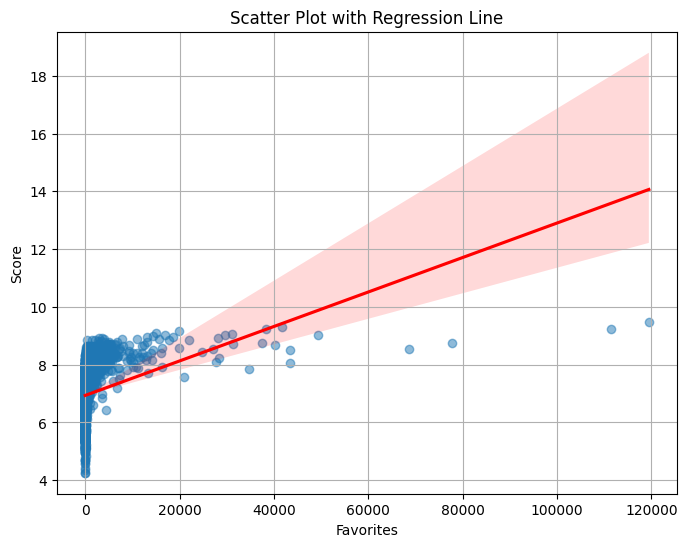

In [42]:
plt.figure(figsize=(8, 6))
sns.regplot(
    x=X_train.squeeze(),  # Ensure x is a Series
    y=y_train, 
    scatter_kws={'alpha': 0.5}, 
    line_kws={'color': 'red'}
)
plt.xlabel("Favorites")
plt.ylabel("Score")
plt.title("Scatter Plot with Regression Line")
plt.grid(True)  # Improve readability
plt.show()


In [43]:
# Identify missing values in 'score'
missing_data = df_reg[df_reg['score'].isna()]
X_test = missing_data[['favorites']]

# Predict missing scores using the trained regressor
y_pred = rf.predict(X_test).round(2)  # Use 'rf' instead of 'regr' and round directly

# Fill missing values with predictions
df_reg.loc[df_reg['score'].isna(), 'score'] = y_pred

# Verify if missing values are filled
print(df_reg.isna().sum())  
print(df_reg.shape)

# Efficiently update df_new with corrected scores instead of merging
df_new.update(df_reg)


favorites    0
score        0
dtype: int64
(64833, 2)


# My Work:

In [44]:
df_anime = pd.read_csv(r"../datasets/anime.csv", on_bad_lines='skip')
df_data = pd.read_csv(r"../datasets/data.csv", on_bad_lines='skip')
df_manga = pd.read_csv(r"../datasets/manga.csv", on_bad_lines='skip')

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/data.csv'

In [ ]:
df_anime.head(10)

,anime_id,title,type,score,scored_by,status,episodes,start_date,end_date,source,...,producers,licensors,synopsis,background,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms
0,5114,Fullmetal Alchemist: Brotherhood,tv,9.10,2037075,finished_airing,64.0,2009-04-05,2010-07-04,manga,...,"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",After a horrific alchemy experiment goes wrong...,NaN,https://cdn.myanimelist.net/images/anime/1208/...,https://myanimelist.net/anime/5114/Fullmetal_A...,https://www.youtube.com/watch?v=--IcmZkvL0Q,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,['Hagane no Renkinjutsushi: Fullmetal Alchemis...
1,11061,Hunter x Hunter (2011),tv,9.04,1671587,finished_airing,148.0,2011-10-02,2014-09-24,manga,...,"['VAP', 'Nippon Television Network', 'Shueisha']",['VIZ Media'],Hunters devote themselves to accomplishing haz...,NaN,https://cdn.myanimelist.net/images/anime/1337/...,https://myanimelist.net/anime/11061/Hunter_x_H...,https://www.youtube.com/watch?v=D9iTQRB4XRk,Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,['HxH (2011)']
2,38524,Shingeki no Kyojin Season 3 Part 2,tv,9.05,1491491,finished_airing,10.0,2019-04-29,2019-07-01,manga,...,"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],Seeking to restore humanity's diminishing hope...,Shingeki no Kyojin adapts content from volumes...,https://cdn.myanimelist.net/images/anime/1517/...,https://myanimelist.net/anime/38524/Shingeki_n...,https://www.youtube.com/watch?v=hKHepjfj5Tw,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,[]
3,9253,Steins;Gate,tv,9.07,1348232,finished_airing,24.0,2011-04-06,2011-09-14,visual_novel,...,"['Frontier Works', 'Media Factory', 'Kadokawa ...",['Funimation'],Eccentric scientist Rintarou Okabe has a never...,Steins;Gate is based on 5pb. and Nitroplus' vi...,https://cdn.myanimelist.net/images/anime/1935/...,https://myanimelist.net/anime/9253/Steins_Gate,https://www.youtube.com/watch?v=27OZc-ku6is,Steins;Gate,STEINS;GATE,[]
4,28851,Koe no Katachi,movie,8.94,1540277,finished_airing,1.0,2016-09-17,2016-09-17,manga,...,"['Shochiku', 'Pony Canyon', 'Kodansha', 'ABC A...","['Eleven Arts', 'NYAV Post']","As a wild youth, elementary school student Sho...",Koe no Katachi won the following awards: Japan...,https://cdn.myanimelist.net/images/anime/1122/...,https://myanimelist.net/anime/28851/Koe_no_Kat...,https://www.youtube.com/watch?v=XBNWo25izJ8,A Silent Voice,聲の形,['The Shape of Voice']
5,32281,Kimi no Na wa.,movie,8.84,1825476,finished_airing,1.0,2016-08-26,2016-08-26,original,...,"['Toho', 'Sound Team Don Juan', 'Amuse', 'JR E...","['Funimation', 'NYAV Post']","Mitsuha Miyamizu, a high school girl, yearns t...",Kimi no Na wa. won the LAFCA Animation Award i...,https://cdn.myanimelist.net/images/anime/5/870...,https://myanimelist.net/anime/32281/Kimi_no_Na_wa,https://www.youtube.com/watch?v=3KR8_igDs1Y,Your Name.,君の名は。,[]
6,2904,Code Geass: Hangyaku no Lelouch R2,tv,8.91,1154270,finished_airing,25.0,2008-04-06,2008-09-28,original,...,"['Bandai Visual', 'Mainichi Broadcasting Syste...","['Funimation', 'Bandai Entertainment']","One year has passed since the Black Rebellion,...",Code Geass: Hangyaku no Lelouch R2 is an origi...,https://cdn.myanimelist.net/images/anime/1088/...,https://myanimelist.net/anime/2904/Code_Geass_...,NaN,Code Geass: Lelouch of the Rebellion R2,コードギアス 反逆のルルーシュ 続編,"['Code Geass: Hangyaku no Lelouch 2nd Season',..."
7,40028,Shingeki no Kyojin: The Final Season,tv,8.80,1237778,finished_airing,16.0,2020-12-07,2021-03-29,manga,...,"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],Gabi Braun and Falco Grice have been training ...,Shingeki no Kyojin: The Final Season adapts co...,https://cdn.myanimelist.net/images/anime/1000/...,https://myanimelist.net/anime/40028/Shingeki_n...,https://www.youtube.com/watch?v=SlNpRThS9t8,Attack on Titan: Final Season,進撃の巨人 The Final Season,"['Shingeki no Kyojin Season 4', 'Attack on Tit..."
8,

In [ ]:
df_manga.head(10)

,manga_id,title,type,score,scored_by,status,volumes,chapters,start_date,end_date,...,demographics,authors,serializations,synopsis,background,main_picture,url,title_english,title_japanese,title_synonyms
0,2,Berserk,manga,9.47,319696,currently_publishing,NaN,NaN,1989-08-25,NaN,...,['Seinen'],"[{'id': 1868, 'first_name': 'Kentarou', 'last_...",['Young Animal'],"Guts, a former mercenary now known as the ""Bla...",Berserk won the Award for Excellence at the si...,https://cdn.myanimelist.net/images/manga/1/157...,https://myanimelist.net/manga/2/Berserk,Berserk,ベルセルク,['Berserk: The Prototype']
1,13,One Piece,manga,9.22,355375,currently_publishing,NaN,NaN,1997-07-22,NaN,...,['Shounen'],"[{'id': 1881, 'first_name': 'Eiichiro', 'last_...",['Shounen Jump (Weekly)'],"Gol D. Roger, a man referred to as the ""King o...",One Piece is the highest selling manga series ...,https://cdn.myanimelist.net/images/manga/2/253...,https://myanimelist.net/manga/13/One_Piece,One Piece,ONE PIECE,[]
2,1706,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,manga,9.30,151433,finished,24.0,96.0,2004-01-19,2011-04-19,...,"['Seinen', 'Shounen']","[{'id': 2619, 'first_name': 'Hirohiko', 'last_...",['Ultra Jump'],"In the American Old West, the world's greatest...",JoJo no Kimyou na Bouken Part 7: Steel Ball Ru...,https://cdn.myanimelist.net/images/manga/3/179...,https://myanimelist.net/manga/1706/JoJo_no_Kim...,NaN,ジョジョの奇妙な冒険 Part7 STEEL BALL RUN,"[""JoJo's Bizarre Adventure Part 7: Steel Ball ..."
3,4632,Oyasumi Punpun,manga,9.02,168459,finished,13.0,147.0,2007-03-15,2013-11-02,...,['Seinen'],"[{'id': 2836, 'first_name': 'Inio', 'last_name...",['Big Comic Spirits'],Punpun Onodera is a normal 11-year-old boy liv...,Oyasumi Punpun was originally serialized in Yo...,https://cdn.myanimelist.net/images/manga/3/266...,https://myanimelist.net/manga/4632/Oyasumi_Punpun,Goodnight Punpun,おやすみプンプン,[]
4,25,Fullmetal Alchemist,manga,9.03,153151,finished,27.0,116.0,2001-07-12,2010-09-11,...,['Shounen'],"[{'id': 1874, 'first_name': 'Hiromu', 'last_na...",['Shounen Gangan'],Alchemists are knowledgeable and naturally tal...,Hagane no Renkinjutsushi won the 49th Shogakuk...,https://cdn.myanimelist.net/images/manga/3/243...,https://myanimelist.net/manga/25/Fullmetal_Alc...,Fullmetal Alchemist,鋼の錬金術師,"['Full Metal Alchemist', 'Hagane no Renkinjuts..."
5,656,Vagabond,manga,9.24,129688,on_hiatus,37.0,327.0,1998-09-03,2015-05-21,...,['Seinen'],"[{'id': 1911, 'first_name': 'Takehiko', 'last_...",['Morning'],"In 16th-century Japan, Shinmen Takezou is a wi...","In 2000, Vagabond won the Japan Media Arts Fes...",https://cdn.myanimelist.net/images/manga/1/259...,https://myanimelist.net/manga/656/Vagabond,Vagabond,バガボンド,[]
6,642,Vinland Saga,manga,9.05,119797,currently_publishing,NaN,NaN,2005-04-13,NaN,...,['Seinen'],"[{'id': 2034, 'first_name': 'Makoto', 'last_na...",['Afternoon'],"Thorfinn, son of one of the Vikings' greatest ...",Vinland Saga won the 13th Japan Media Arts Awa...,https://cdn.myanimelist.net/images/manga/2/188...,https://myanimelist.net/manga/642/Vinland_Saga,Vinland Saga,ヴィンランド・サガ,[]
7,90125,Kaguya-sama wa Kokurasetai: Tensai-tachi no Re...,manga,8.92,123341,finished,28.0,281.0,2015-05-19,2022-11-02,...,['Seinen'],"[{'id': 2139, 'first_name': 'Aka', 'last_name'...",['Young Jump'],Considered a genius due to having the highest ...,Kaguya-sama wa Kokurasetai: Tensai-tachi no Re...,https://cdn.myanimelist.net/images/manga/3/188...,https://myanimelist.net/manga/90125/Kaguya-sam...,Kaguya-sama: Love Is War,かぐや様は告らせたい～天才たちの恋愛頭脳戦～,"[""Kaguya Wants to be Confessed To: The Geniuse..."
8,116778,Chainsaw Man,manga,8.75,350057,currently_publishing,NaN,NaN,2018-12-03,NaN,...,['Shounen'],"[{'id': 41158, 'first_name': 'Tatsuki', 'last_...",['Shounen Jump+'],Denji has a simple dream—to live a happy and p...,"As part of the JUMP START initiative, the firs...",https://cdn.myanimelist.net/images/manga/3/216...,https://myanimelist.net/manga/116778/Chainsaw_Man,Chainsaw Man,チェンソーマン,[]
9,1,Monster

In [ ]:
df_manga.columns

Index(['manga_id', 'title', 'type', 'score', 'scored_by', 'status', 'volumes',
       'chapters', 'start_date', 'end_date', 'members', 'favorites', 'sfw',
       'approved', 'created_at_before', 'updated_at', 'real_start_date',
       'real_end_date', 'genres', 'themes', 'demographics', 'authors',
       'serializations', 'synopsis', 'background', 'main_picture', 'url',
       'title_english', 'title_japanese', 'title_synonyms'],
      dtype='object')

In [ ]:
df_manga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64833 entries, 0 to 64832
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   manga_id           64833 non-null  int64  
 1   title              64833 non-null  object 
 2   type               64833 non-null  object 
 3   score              24636 non-null  float64
 4   scored_by          64833 non-null  int64  
 5   status             64833 non-null  object 
 6   volumes            48211 non-null  float64
 7   chapters           46042 non-null  float64
 8   start_date         62950 non-null  object 
 9   end_date           51932 non-null  object 
 10  members            64833 non-null  int64  
 11  favorites          64833 non-null  int64  
 12  sfw                64833 non-null  bool   
 13  approved           64833 non-null  bool   
 14  created_at_before  64833 non-null  object 
 15  updated_at         62678 non-null  object 
 16  real_start_date    629

In [ ]:
df_manga["type"].unique()

array(['manga', 'manhwa', 'light_novel', 'one_shot', 'manhua', 'novel',
       'doujinshi'], dtype=object)

In [ ]:
df_manga["status"].unique()

array(['currently_publishing', 'finished', 'on_hiatus', 'discontinued'],
      dtype=object)

In [ ]:
df_manga["genres"].unique()

array(["['Action', 'Adventure', 'Award Winning', 'Drama', 'Fantasy', 'Horror', 'Supernatural']",
       "['Action', 'Adventure', 'Fantasy']",
       "['Action', 'Adventure', 'Mystery', 'Supernatural']", ...,
       "['Boys Love', 'Mystery', 'Suspense']",
       "['Comedy', 'Drama', 'Gourmet', 'Romance']",
       "['Fantasy', 'Mystery', 'Supernatural', 'Suspense']"],
      shape=(1806,), dtype=object)

In [ ]:
# Flatten the lists in the "genres" column and extract unique values
import ast

# Convert the string representation of lists into actual lists
df_manga["genres"] = df_manga["genres"].apply(ast.literal_eval)

# Flatten the lists and get unique values
unique_genres = set(genre for sublist in df_manga["genres"] for genre in sublist)

# Display the unique genres
print(unique_genres)

{'Gourmet', 'Sci-Fi', 'Romance', 'Supernatural', 'Ecchi', 'Horror', 'Avant Garde', 'Mystery', 'Award Winning', 'Hentai', 'Slice of Life', 'Fantasy', 'Girls Love', 'Boys Love', 'Drama', 'Adventure', 'Suspense', 'Comedy', 'Action', 'Sports', 'Erotica'}


In [ ]:
unique_genres_np=np.array(unique_genres)
unique_genres_np

array({'Gourmet', 'Sci-Fi', 'Romance', 'Supernatural', 'Ecchi', 'Horror', 'Avant Garde', 'Mystery', 'Award Winning', 'Hentai', 'Slice of Life', 'Fantasy', 'Girls Love', 'Boys Love', 'Drama', 'Adventure', 'Suspense', 'Comedy', 'Action', 'Sports', 'Erotica'},
      dtype=object)

In [ ]:
df_manga["themes"].unique()

array(["['Gore', 'Military', 'Mythology', 'Psychological']", '[]',
       "['Historical']", ..., "['Childcare', 'Medical']",
       "['Gore', 'High Stakes Game']", "['Adult Cast', 'Memoir']"],
      shape=(1009,), dtype=object)

In [ ]:
# Flatten the lists in the "genres" column and extract unique values
import ast

# Convert the string representation of lists into actual lists
#df_manga["themes"] = df_manga["themes"].apply(ast.literal_eval)

# Flatten the lists and get unique values
unique_themes = set(genre for sublist in df_manga["themes"] for genre in sublist)

# Display the unique genres
print(unique_themes,len(unique_themes))

{'s', 'c', 'g', 'A', 'r', 'h', 'x', 'w', 'o', 'n', ',', 'z', 'E', ')', '[', 'S', 'i', 'l', 'y', 'q', 'v', 'I', 'W', 'M', 'C', 'O', 'D', 'V', 'G', "'", ' ', ']', 'u', 'H', 'L', 'a', 'd', 'f', 'e', '(', 'j', 'p', 'm', 'b', 'F', 'T', 't', 'P', 'k', 'R'} 50


In [ ]:
df_manga["demographics"].unique()

array(["['Seinen']", "['Shounen']", "['Seinen', 'Shounen']", '[]',
       "['Shoujo']", "['Josei']", "['Kids']", "['Kids', 'Shounen']",
       "['Seinen', 'Shoujo']", "['Kids', 'Shoujo']", "['Kids', 'Seinen']",
       "['Josei', 'Seinen']", "['Shoujo', 'Shounen']",
       "['Josei', 'Kids']"], dtype=object)

In [ ]:
# Flatten the lists in the "genres" column and extract unique values
import ast

# Convert the string representation of lists into actual lists
#df_manga["themes"] = df_manga["themes"].apply(ast.literal_eval)

# Flatten the lists and get unique values
unique_demographics = set(genre for sublist in df_manga["demographics"] for genre in sublist)

# Display the unique genres
print(unique_themes,len(unique_themes))

{'s', 'c', 'g', 'A', 'r', 'h', 'x', 'w', 'o', 'n', ',', 'z', 'E', ')', '[', 'S', 'i', 'l', 'y', 'q', 'v', 'I', 'W', 'M', 'C', 'O', 'D', 'V', 'G', "'", ' ', ']', 'u', 'H', 'L', 'a', 'd', 'f', 'e', '(', 'j', 'p', 'm', 'b', 'F', 'T', 't', 'P', 'k', 'R'} 50


In [ ]:
df_manga["serializations"].unique()

array(["['Young Animal']", "['Shounen Jump (Weekly)']", "['Ultra Jump']",
       ..., "['Bekkan Getsumaga']", "['JusToon']", "['Le Noël']"],
      shape=(1253,), dtype=object)

In [ ]:
df_manga["serializations"].unique().shape

(1253,)

In [ ]:
df_manga.shape

(64833, 30)